In [1]:
import numpy as np
import pandas as pd
import pdfplumber
import xarray as xr
from pathlib import Path
from typing import Dict, Any


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
sns.set_style("whitegrid")

#Bayes
import pymc as pm
import arviz as az
import pytensor.tensor as pt

#Make sure it can see the system path
from pathlib import Path
import sys

# Add parent directory of the notebook (the project root) to sys.path
ROOT = Path().resolve().parent   # X/
sys.path.insert(0, str(ROOT))

#Other modules
from utils import data_utils
from bayes import DATA_DIR,process


In [11]:
coords=data_utils.get_coords()

# Load the evidence

The evidence consists of:
* CMIP6 Earth system model estimates of $\beta_L$ and $\gamma_L$
* A few targeted model experiments with and without specific processes
* Observations of atmospheric CO$_2$ internal variability amplitude


In [3]:
process_evidence=data_utils.load_process_evidence(kind="2xCO2")
emergent_contraint_evidence=data_utils.load_emergent_constraint_evidence()
cmip_evidence=data_utils.load_CMIP_land_data(kind="2xCO2")

evidence = process_evidence | emergent_contraint_evidence | cmip_evidence

# Define the models
SHORT SUMMARY: 
1) We use process-based runs from ACCESS and UKESM to estimate how the inclusion of fire, dynamic vegetation, and nitrogen limitations affect $\beta_L$ and $\gamma_L$.  

2) Then we use an emergent constraint, letting observed interannual variability tell us about the tropical land climate resonse.  

3. Finally, we use Earth system models' reported $\beta$ and $\gamma$ to give us final estimates of CMIP-constrained  $\beta_L$ and $\gamma_L$, taking into account both inter-model spread and the processes included in each CMIP6 model.

LONGER, MORE MATHEMATICAL TREATMENT:
## 1. Processes
We model the land CO$_2$ effect and the climate effects with and without various processes.

We assume that for each process $j$ (where $j$ is one of ["nitrogen","fire","vegetation"]) the single-process evidence from ESM $i$ is 
$$\eta_{j}^i \sim N(\eta_{j},\tau_{\eta}^{-1})$$
and 
$$\nu_{j}^i \sim N(\nu_{j},\tau_{\nu}^{-1})$$
where $\eta_j$ and $\nu_j$ are the true real-world values of the scaling factors associated with process $j$.

### Parameters in our process model
* $\eta_j$: How does process $j$ scale up or down the land CO$_2$ effect $\beta_L$?
* $\nu_j$: How does process $j$ scale up or down the land climate effect $\gamma_L$?
* $\tau_{\eta}$: How much inter-CMIP spread do we expect in $\eta$?  How representative will a single result be of all Earth system model simulations?
* $\tau_{\nu}$: How much inter-CMIP spread do we expect in $\nu$?  How representative will a single result be of all Earth system model simulations?
### Caveats

* Right now I assume no cross-correlations between $\eta$ and $\nu$. It might be reasonable (if more complicated) to assume a model with large $\eta_{N}$ (or whatever) also has large $\gamma_N$.
* I assume a single $\tau_{\nu}$ or $\tau_{\beta}$ for every process.

### To do
* Add permafrost as an additive term

## 2. Emergent Constraints
We include an emergent constraint using observed interannual variability.  
For each CMIP6 model $i = 1,\dots,N$, let $IAV^{(i)}$ and 
$\gamma_{LT}^{(i)}$ denote the latent true interannual variability 
and long-term sensitivity.  
We assume a linear emergent relationship
$$
    \gamma_{LT}^{(i)} = m \, IAV^{(i)} + b .
$$

But we don't know each model's "true" tropical climate response and its own interannual variability - only the noisy estimates ($\widehat{IAV}^{(i)}$ and $\widehat{\gamma_{LT}}^{(i)}$)  reported in Zechlau et al (2022).  So to take unto account the uncertainty in CMIP6 model values, we model

$$ \widehat{IAV}^{(i)} \sim \mathcal{N}\!\left( IAV^{(i)}, \; \sigma_{IAV}^{(i)} \right)$$
and 
$$ \widehat{\gamma_{LT}}^{(i)} \sim \mathcal{N}\!\left( \gamma_{LT}^{(i)}, \; \sigma_{\gamma}^{(i)} \right)$$

The observed-system interannual variability is treated as a latent true
quantity $IAV_{\text{obs}}$ with observational estimate 
$IAV_{\text{obs}}^{\,\text{obs}}$ and known uncertainty $\sigma_{\text{obs}}$:
\begin{equation}
    IAV_{\text{obs}}^{\,\text{obs}}
        \sim \mathcal{N}\!\left( IAV_{\text{obs}},\, \sigma_{\text{obs}}^{2} \right).
\end{equation}

So the emergent-constraint estimate of long-term sensitivity is
\begin{equation}
    \gamma_{LT}^{\text{obs}} = m \, IAV_{\text{obs}} + b .
\end{equation}


### Parameters in our emergent constraint model
* $\gamma_{LT}$: Tropical land climate response
* $m$: Slope of the emergent constraint line
* $b$: Y-intercept of the emergenct constraint line

### Caveats

* The relationship between $IAV$ and $\gamma_{LT}$ is asumed to be linear and the functional form shown in models is assumed to apply to the observations.


### To do
* Nothing?

## 3. Statistical model for CMIP
We assume 1) $\beta$ and $\gamma$ are correlated with one another across CMIP6 models 2) there is an intrinsic model spread (ie we use a random-effects model that allows for inter-model difference, not the fixed-effect model that assumes each CMIP6 result is a random draw from a normal distribution) 3) The $\beta$ and $\gamma$ from each CMIP model can tell us about those parameters and the scaling factors, depending on which processes it includes.


We define the unscaled CO$_2$/climate effects $B$ and $G$ as those we would observe in the absence of the processes:
$$B = \beta_L \prod_{j=1}^{P} \eta_j^{-1} $$
$$G = \gamma_L \prod_{j=1}^{P} \nu_j^{-1} $$
$$\qquad j = [\rm{nitrogen, fire, vegetation}]$$
Each CMIP model (i) has land feedbacks $D_i=(\beta_i,\gamma_i)$ which treated as noisy draws from the CMIP6 archive, which is assumed to have intrinsic spread $\Sigma$:
$$ 
D_i \sim N(\mu_i,\Sigma).
$$
Each model's $\mu_i$ can be rewritten in terms of the scaling factors:
$$
\mu_i =
\begin{pmatrix}
\beta_i \\
\gamma_i
\end{pmatrix}
=
\begin{pmatrix}
\eta_i^{\mathrm{eff}}\, B \\
\nu_i^{\mathrm{eff}}\, G
\end{pmatrix}
$$
where the effective scaling factors depend on the processes included in the model:
$$
\eta_i^{\mathrm{eff}} = \prod_{j=1}^{P} \eta_j^{L_{j,i}} \\
\nu_i^{\mathrm{eff}} = \prod_{j=1}^{P} \nu_j^{L_{j,i}}
$$
The matrix $L$ is a lookup table that specifies whether or not a model includes process $j$:
$$
L_{j,i} =
\begin{cases}
1, & \text{if CMIP model } i \text{ includes process } j, \\
0, & \text{otherwise}.
\end{cases}
$$

### Caveats
* I'm neglecting the relationships beween CMIP model spread in the scaling factors $\tau_{\eta}$ and $\tau_{\nu}$ and the CMIP6 model spread in $\beta$ and $\gamma$ (the covariance matrix $\Sigma$).  This can be explicitly modeled but it makes the code ugly and very slow.
### Parameters in our CMIP model
Note that the priors for the scaling factors and the tropical land climate response are the posteriors from the process and emergent constraint models, respectively

* $\gamma_{LT} \sim p(\gamma_{LT} \mid  \gamma_{LT}^{\text{obs}}  , IAV_{\text{obs}} )$: Tropical land climate response (already updated by emergent constraint evidence)
* $\gamma_{LX}$: extratropical land climate response
* $ \gamma_L = \gamma_{LX} + \gamma_{LT}$: Total land climate response (deterministic)
* $\beta_L$: Total land CO$_2$ response
* $\eta_j \sim p(\eta_j \mid \mathcal{E}_{\mathrm{proc}})$: Scaling factors for $\beta_L$ (already updated from process evidence)
* $\nu_j \sim p(\nu_j \mid \mathcal{E}_{\mathrm{proc}})$: Scaling factors for $\gamma_L$ (already updated from process evidence)
* $\Sigma$: Intrinsic model spread in $\beta_L$, $\gamma_L$, and the covariance between $\beta_L$ and $\gamma_L$.


### To do
* Model uncertainties in $\beta_i$ and $\gamma_i$ WITHIN a particular CMIP model (similar to those given in Zechlau et al (2022)- where did these come from?
* Add permafrost (additive) term (I don't think we have any single-process permafrost runs, though)

## 4. Model for $\alpha$ 
Wait for Thorsten and TCR process group
### To do:
* We probably want to model $\alpha$ as correlated in climate models with $\beta$ and $\gamma$- this will make the mean $\mu_i = (\alpha_i,\beta_i,\gamma_i)$ and $\Sigma$ will be a 3x3 covariance matrix.

## 5. Model for oceanic parameters
???

## 6. Overall model
We can get the posterior for TCRE 
$$P(\rm{TCRE}|\rm{data}) = \int \delta \left(\rm{TCRE}-f(\alpha,\beta,\gamma)\right) p(\alpha,\beta,\gamma| \rm{data}) \, d\alpha \, d\beta \, d\gamma$$
where
$$
f(\alpha,\beta,\gamma) = \frac{\alpha}{1+\beta+\gamma}
$$
(CHECK THE UNITS)

# Set the priors

## Unavoidable decisions
We can't get out of making choices about the interpretive models and their parameters.  

### Priors on $\beta_L$ and $\gamma_L$

Here, I'm defining priors (as opposed to hyperpriors) to be our initial informed guesses about the parameters that map onto real-world physical processes.  I've split these up into priors on the full land CO$_2$ response $\beta_L$ and on the tropical ($\gamma_{LT}$) and extratropical $\gamma_{LX}$ climate responses:

In [4]:
beta_gamma_priors={"βL":lambda name: pm.Uniform(name,0,10),\
       "γLX": lambda name: pm.Normal(name,-100,100),\
       "γLT": lambda name: pm.Normal(name,-100,100)}

### Priors on scaling factors 


In [5]:
# process priors

beta_scaling_priors={"η_nitrogen": lambda name: pm.Uniform(name,0.001,1),\
            "η_fire": lambda name: pm.Uniform(name,0.001,2),\
            "δβ_permafrost": lambda name: pm.Normal(name,1.0,.00001),\
            "η_vegetation": lambda name: pm.Uniform(name,0.001,2)}

gamma_scaling_priors={"ν_nitrogen": lambda name: pm.Uniform(name,0.001,1),\
            "ν_fire": lambda name: pm.Uniform(name,0.001,2),\
            "δγ_permafrost": lambda name: pm.Normal(name,-100.0,100),\
            "ν_vegetation": lambda name: pm.Uniform(name,0.001,2)}

proc_priors=beta_scaling_priors | gamma_scaling_priors

priors = beta_gamma_priors | proc_priors

# Set the hyperpriors (Or use defaults)
You can think of these as nuisances: they apply to parameters in the forward models we use to make sense of our evidence.   I've split these up into hyperpriors on the process evidence, hyperpriors on the emergent constraint parameters, and hyperpriors on the CMIP6 covariance matrix.

In [6]:
#Assume model spread in scaling is the same for every process
#This is the PRECISION: 1/sigma (for numerical stability)
#The bigger it is the more representative a single process-based run will be
hyperpriors_process={"τ_eta": lambda name: pm.HalfNormal(name,100),\
            "τ_nu": lambda name: pm.HalfNormal(name,100)}

# Priors on the slope and y-intercept of the emergent constraint line
hyperpriors_ec = {'m': lambda name: pm.Normal(name,0,10),
        'b': lambda name: pm.Normal(name,0,10)}

# Priors on CMIP model structural spread
hyperpriors_cov = {"chol": lambda name: pm.LKJCholeskyCov(
    name,
    n=len(coords["parameter"]),
    eta=2.0,         # Strength of the LKJ prior; 1 = uniform over correlations
    sd_dist=pm.HalfNormal.dist(100.0)
            )}

hyperpriors = hyperpriors_process | hyperpriors_ec | hyperpriors_cov


# Validate the priors
Make sure we've specified everything we need

In [7]:
data_utils.validate_priors(priors,hyperpriors=hyperpriors)

## STEP 1: Use the single-process runs to estimate the scaling factors
Right now we don't know much about the scaling factors because we don't have very many process runs.  The posteriors on $\nu$ and $\gamma$ for each process are going to depend very strongly on two things: 
* our priors on the scaling factors
* how much model spread in the scaling factors we expect there to be

The former is controlled by our physical intuition, as specified above.  The latter is controlled by the $\tau$ parameter.  If the model spread in the scaling factor is assumed to be small, then even a single process-based run will be very informative about the scaling factor.  If it's big, then a single process-based run tells us almost nothing at all.

The more single-process runs we get, the more we can constrain both the scaling factor and the model spread.


### Mathematical model
We assume that for each process $j$ (where $j$ is one of ["nitrogen","fire","vegetation"]) the single-process evidence from ESM $i$ is 
$$\eta_{j}^i \sim N(\eta_{j},\tau_{\eta}^{-1})$$
and 
$$\nu_{j}^i \sim N(\nu_{j},\tau_{\nu}^{-1})$$
where $\eta_j$ and $\nu_j$ are the true real-world values of the scaling factors associated with process $j$.

### Caveats

* Right now I assume no cross-correlations between $\eta$ and $\nu$. It might be reasonable (if more complicated) to assume a model with large $\eta_{N}$ (or whatever) also has large $\gamma_N$.
* I assume a single $\tau_{\nu}$ or $\tau_{\beta}$ for every process.

# Results from the process model

In [9]:
with pm.Model() as test_process_model:
    params=process.make_process_model(test_process_model,evidence,priors,hyperpriors)
    test_process_trace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_nitrogen, η_fire, η_vegetation, τ_eta, τ_nu, ν_nitrogen, ν_fire, ν_vegetation]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


## Scaling factors for $\beta_L$
Because we have so few process-based runs, these are going to depend heavily on our assumptions about the inter-model spread in scaling factors.

array([<Axes: title={'center': 'η_nitrogen'}>,
       <Axes: title={'center': 'η_fire'}>,
       <Axes: title={'center': 'η_vegetation'}>], dtype=object)

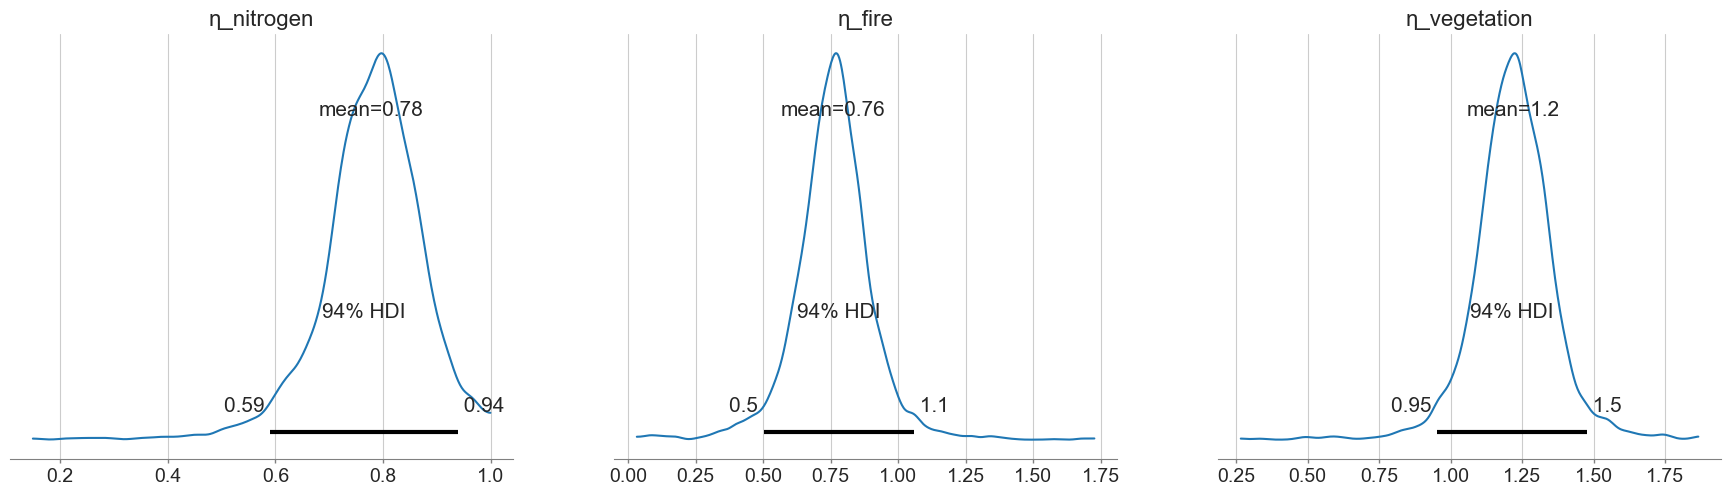

In [12]:
az.plot_posterior(test_process_trace,var_names=[f"η_{proc}" for proc in coords["process"]])

## Scaling factors for $\gamma_L$
Because we have so few process-based runs, these are going to depend heavily on our assumptions about the inter-model spread in scaling factors as well as on our priors.  We've put a uniform prior on $\nu_{nitrogen}$ that truncates at 1; the evidence does not necessarily support that $\nu_{nitrogen}$ is less than 1.

array([<Axes: title={'center': 'ν_nitrogen'}>,
       <Axes: title={'center': 'ν_fire'}>,
       <Axes: title={'center': 'ν_vegetation'}>], dtype=object)

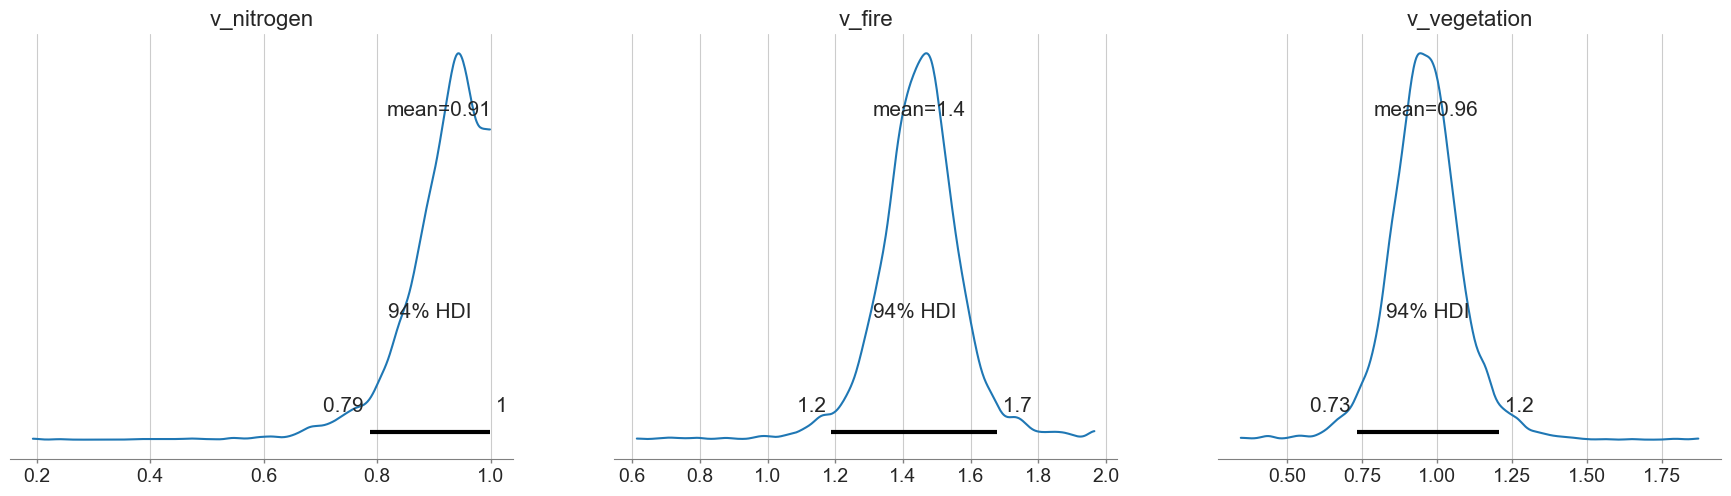

In [13]:
az.plot_posterior(test_process_trace,var_names=[f"ν_{proc}" for proc in coords["process"]])

# Results from the emergent constraint model

In CMIP6, the (uncertain) tropical climate effect $\gamma_{LT}$ appears related to the (uncertain) interannual variability in atmospheric carbon, which is an observable quantity:


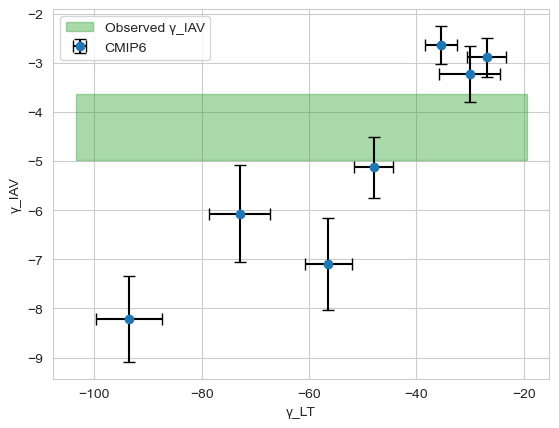

In [14]:
X=evidence['γ_LT']
Y=evidence['γ_IAV']
Xerr=evidence['σ_LT']
Yerr=evidence['σ_IAV']
plt.errorbar(
    X, Y,
    xerr=Xerr,
    yerr=Yerr,
    fmt='o',            # marker style
    ecolor='black',      # error bar color
    capsize=4,           # size of the caps
    linestyle='none',    # no line connecting points
    label='CMIP6'     # label
)
plt.xlabel('γ_LT')
plt.ylabel('γ_IAV')

lower=evidence["IAV_observed_mean"]- evidence["IAV_observed_std"]
upper=evidence["IAV_observed_mean"]+ evidence["IAV_observed_std"]
xax=np.linspace(*plt.xlim(),10)
plt.fill_between(xax,np.zeros_like(xax)+lower,np.zeros_like(xax)+upper,color=cm.tab10(2),alpha=.4,\
                label="Observed γ_IAV")
plt.legend()

In [15]:
with pm.Model() as ec_test_model:
    test=process.make_emergent_constraint_model(ec_test_model,emergent_contraint_evidence,priors,hyperpriors)
    ec_test_trace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γLT, m, b, γLT_CMIP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


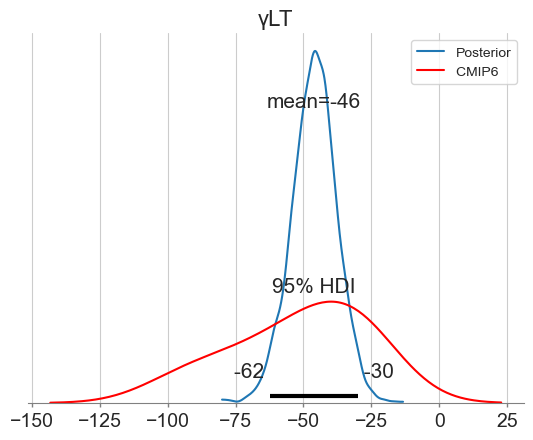

In [16]:
az.plot_posterior(ec_test_trace.posterior.γLT,label="Posterior",hdi_prob=.95)
sns.kdeplot(evidence["γ_LT"],color="r",label="CMIP6 ")
plt.legend()

# Results from the CMIP statistical model


In [18]:
with pm.Model() as cmip_model:
    cmip_params=process.make_covariance_model(cmip_model,evidence,priors,hyperpriors)
    cmip_trace=pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_nitrogen, η_fire, η_vegetation, τ_eta, τ_nu, ν_nitrogen, ν_fire, ν_vegetation, γLX, γLT, m, b, γLT_CMIP, βL, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 116 seconds.


<Axes: title={'center': 'γL'}, ylabel='Density'>

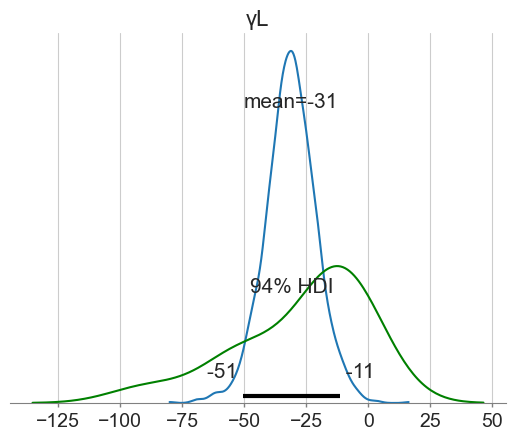

In [19]:
az.plot_posterior(cmip_trace.posterior.γL)
#az.plot_posterior(ec_test_trace.posterior.γLT,ax=plt.gca(),c="r")
sns.kdeplot(evidence["γL_cmip"],ax=plt.gca(),c="g")

The posteriors for $\gamma_L$ and $\beta_L$ are correlated because the evidence of the models suggests they should be

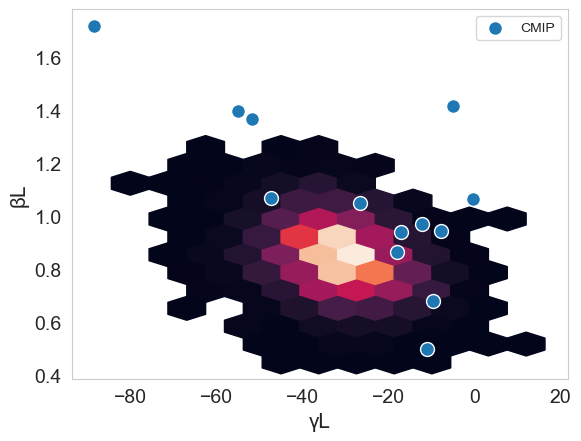

In [20]:
az.plot_pair(cmip_trace,var_names=["γL","βL"],kind="hexbin")
plt.scatter(evidence["γL_cmip"],evidence["βL_cmip"],label="CMIP",edgecolor="w",s=100)
plt.legend()